In [1]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
#Display all content in dataframe
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


### Load adult dataset, label encoding dataset

In [2]:
file_path = '../data/adult.csv'
original_adult = pd.read_csv(file_path, index_col=0)

# label encoding dataset
label_adult = ssd.DataEncoder(original_adult).label_encoding()
label_adult.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


### Show Feature Importance on dataset

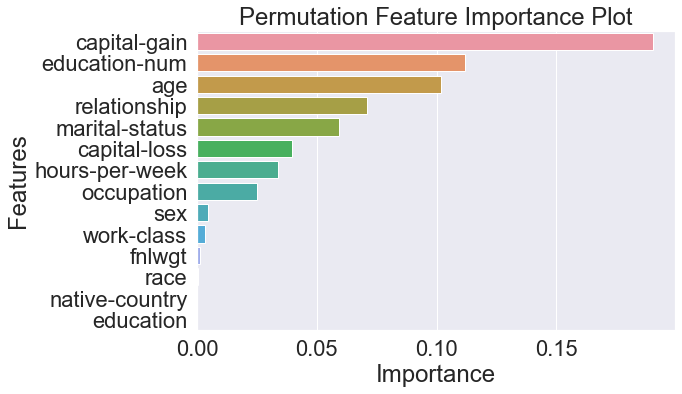

In [3]:
x_train, y_train = label_adult.drop('income', axis=1), label_adult[['income']]
# init lightgbm model
label_lgb_model = ssd.InitializeModel(x_train, y_train).lgb_clf_model()
# construct FeamtureImportance class, to visualize feature importance
label_feature_imp = ssd.FeatureImportance(x_train, y_train, label_lgb_model)
label_imp = label_feature_imp.permutation_importance()
label_feature_imp.vis_perm_importance(label_imp)

### Calculate Shapley values

In [4]:
tree_shap = ssd.ShapValues(x_train, label_lgb_model, explainer_type='Tree')

Saving figure summary_plot_1563461151


I0718 16:45:58.604387 4462753216 logging_custom.py:46] shap_summary_plot running time: 0M:13s:65ms


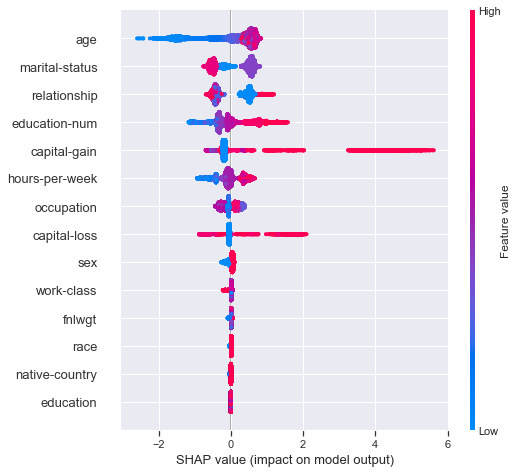

In [5]:
# show shap summary plot
tree_shap.shap_summary_plot()

Saving figure dependence_plot_education-num_1563461169


I0718 16:46:10.268942 4462753216 logging_custom.py:46] shap_dependence_plot running time: 0M:5s:218ms


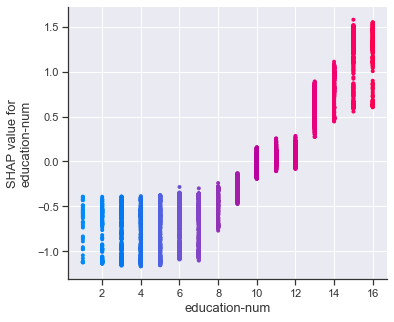

In [6]:
attr = 'education-num'
tree_shap.shap_dependence_plot(ind=attr, interaction_index=attr)

### Exp1: Binary variable flip, target is "prediction change" after flipping

In [7]:
# construct BinaryFlip class
flip_attr = 'sex'
b_flip = ssd.BinaryFlip(x_train, y_train, label_lgb_model, flip_attr)

In [8]:
# effect from "male" to "female"
df_male = b_flip.calc_flip_effect()
df_male_effect = original_adult.copy()
target_name = df_male.columns[-1]
df_male_effect[target_name] = df_male[target_name]
# df_male_effect = pd.concat([df_male_effect, df_male[[target_name]]], axis=1)
df_male_effect.head()

sex effect from "1" to "0"


,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,sex_effect
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0.011295
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0.005336
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.011652
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0.019692
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,-0.001219


In [8]:
def subgroup_discovery(df_effect, flip_attr, target_name, measure):
    target = ssd.NumericTarget(target_name)
    search_space = ssd.create_selectors(df_effect, ignore=[flip_attr, target_name, 'income'])
    task = ssd.SubgroupDiscoveryTask(df_effect, target, search_space, qf=measure, result_set_size=10)
    result = ssd.BeamSearch().execute(task)
#     result = spd.overlap_filter(result, df_effect, similarity_level=0.85)
    df_result = ssd.as_df(df_effect, result, statistics_to_show=ssd.all_statistics_numeric)
    return df_result[['quality', 'subgroup', 'size_sg', 'mean_sg', 'mean_dataset', 'mean_lift']]

**Standard Numeric Measure**

In [10]:
df_std_num = subgroup_discovery(df_male_effect, flip_attr, target_name, ssd.StandardQFNumeric(1))
df_std_num

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,265.393938,relationship= Husband AND capital-gain: [0:114[ AND capital-loss: [0:155[,10739.0,0.047633,0.02292,2.078216
1,261.712144,relationship= Husband AND marital-status= Married-civ-spouse AND capital-gain: [0:114[,11587.0,0.045507,0.02292,1.985443
2,261.664993,relationship= Husband AND capital-gain: [0:114[,11595.0,0.045487,0.02292,1.984586
3,253.952428,marital-status= Married-civ-spouse AND capital-loss: [0:155[ AND relationship= Husband,12328.0,0.043520,0.02292,1.898749
4,253.882474,relationship= Husband AND capital-loss: [0:155[,12337.0,0.043499,0.02292,1.897846
5,250.223482,relationship= Husband AND marital-status= Married-civ-spouse,13184.0,0.041900,0.02292,1.828056
6,250.153528,relationship= Husband,13193.0,0.041881,0.02292,1.827259
7,244.213036,relationship= Husband AND native-country= United-States AND capital-gain: [0:114[,10408.0,0.046384,0.02292,2.023718
8,242.454673,race= White AND relationship= Husband AND capital-gain: [0:114[,10473.0,0.046071,0.02292,2.010039
9,238.896568,marital-status= Married-civ-spouse AND capital-loss: [0:155[ AND capital-gain: [0:114[,12199.0,0.042504,0.02292,1.854406


**Incremental Numeric Measure**

In [11]:
df_inc_num = subgroup_discovery(df_male_effect, flip_attr, target_name, ssd.IncrementalQFNumeric(1))
df_inc_num

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.013467,relationship= Husband AND capital-gain: [0:114[,11595.0,0.045487,0.02292,1.984586
1,0.012667,relationship= Husband AND capital-loss: [0:155[,12337.0,0.043499,0.02292,1.897846
2,0.012077,relationship= Husband AND marital-status= Married-civ-spouse,13184.0,0.041900,0.02292,1.828056
3,0.012069,relationship= Husband,13193.0,0.041881,0.02292,1.827259
4,0.011900,relationship= Husband AND native-country= United-States,11861.0,0.042637,0.02292,1.860225
5,0.011770,relationship= Husband AND race= White,11940.0,0.042357,0.02292,1.848000
6,0.011417,age: [41:50[ AND relationship= Husband,3384.0,0.058336,0.02292,2.545174
7,0.011255,marital-status= Married-civ-spouse AND capital-gain: [0:114[,13157.0,0.040626,0.02292,1.772505
8,0.010806,relationship= Husband AND work-class= Private,8572.0,0.043981,0.02292,1.918862
9,0.010427,marital-status= Married-civ-spouse AND capital-loss: [0:155[,14018.0,0.038811,0.02292,1.693314


**Decision Tree visulization**

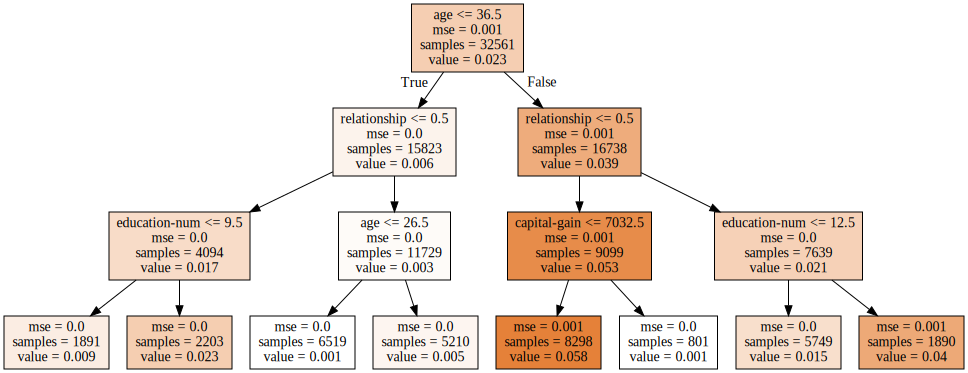

In [15]:
dtree_exp = ssd.DecisionTreeExplain(x_train, df_male[target_name])
estimator = dtree_exp.dtree_reg_model(max_depth=3)
dtree_exp.visualize_dtree(estimator, 'test')

### Exp2: Numeric variable pertubation

**Age Pertubation**

In [4]:
perturb_attr = 'age'
n_perturb = ssd.NumericPerturb(x_train, y_train, label_lgb_model, perturb_attr)
# effect of perturb "age" value
df_perturb = n_perturb.calc_perturb_effect()
df_perturb.head()
ignore_attr = list(df_perturb.columns[-2:])
df_perturb_effect = pd.concat([original_adult, df_perturb[ignore_attr]], axis=1)
df_perturb_effect.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_change,age_prediction_change
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,33,0.002934
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,31,0.335236
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2,0.006984
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,7,0.000000
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,12,0.140273


In [5]:
# age change and prediction change as the complext target
target = ssd.ComplexTarget((ignore_attr[0], ignore_attr[1]))
search_space = ssd.create_selectors(df_perturb_effect, ignore=[ignore_attr[0], ignore_attr[1], 'income', 'age'])
task = ssd.SubgroupDiscoveryTask(df_perturb_effect, target, search_space, qf=ssd.CorrelationQF('entropy'), result_set_size=10)
result = ssd.BeamSearch().execute(task)
# result = ssd.overlap_filter(result, df_perturb_effect, similarity_level=0.85)
df_result_age = ssd.as_df(df_perturb_effect, result, statistics_to_show=ssd.complex_statistics, complex_target=True)
df_result_age

,quality,subgroup,sg_size,dataset_size,complement_sg_size,sg_corr,dataset_corr,complement_sg_corr,corr_lift
0,0.1382,marital-status= Married-civ-spouse AND hours-per-week: [40:41[,7095.0,32561.0,25466.0,0.458718,0.276063,0.276032,1.661644
1,0.1377,relationship= Husband AND hours-per-week: [40:41[,6275.0,32561.0,26286.0,0.470700,0.276063,0.276032,1.705047
2,0.1376,relationship= Husband AND sex= Male AND hours-per-week: [40:41[,6274.0,32561.0,26287.0,0.470646,0.276063,0.276032,1.704851
3,0.1375,marital-status= Married-civ-spouse AND relationship= Husband AND hours-per-week: [40:41[,6273.0,32561.0,26288.0,0.470584,0.276063,0.276032,1.704626
4,0.1370,marital-status= Married-civ-spouse AND sex= Male AND hours-per-week: [40:41[,6347.0,32561.0,26214.0,0.468493,0.276063,0.276032,1.697054
5,0.1365,marital-status= Married-civ-spouse AND hours-per-week: [40:41[ AND native-country= United-States,6201.0,32561.0,26360.0,0.470403,0.276063,0.276032,1.703971
6,0.1359,marital-status= Married-civ-spouse AND hours-per-week: [40:41[ AND capital-gain: [0:114[,6338.0,32561.0,26223.0,0.467126,0.276063,0.276032,1.692102
7,0.1355,relationship= Husband AND native-country= United-States AND hours-per-week: [40:41[,5516.0,32561.0,27045.0,0.482430,0.276063,0.276032,1.747538
8,0.1353,relationship= Husband AND capital-gain: [0:114[ AND hours-per-week: [40:41[,5615.0,32561.0,26946.0,0.480075,0.276063,0.276032,1.739007
9,0.1339,relationship= Husband AND capital-loss: [0:155[ AND hours-per-week: [40:41[,5913.0,32561.0,26648.0,0.471872,0.276063,0.276032,1.709292


**Age increment by 10**

In [10]:
target_name = '{}_prediction_change'.format(perturb_attr)
df_age_increment = n_perturb.calc_add_effect()
df_age_increment = pd.concat([original_adult, df_age_increment[target_name]], axis=1)
df_age_increment.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_prediction_change
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0.005607
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,-0.004205
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.005558
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,-0.015652
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0.137000


In [11]:
df_age_effect = subgroup_discovery(df_age_increment, perturb_attr, target_name, ssd.IncrementalQFNumeric(1))
df_age_effect

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.008959,education-num>=13 AND marital-status= Never-married,2365.0,0.056684,0.023443,2.417999
1,0.008489,work-class= Private AND marital-status= Married-civ-spouse,9732.0,0.038970,0.023443,1.662352
2,0.008157,marital-status= Married-civ-spouse AND education= Some-college AND work-class= Private,1858.0,0.057639,0.023443,2.458718
3,0.008157,work-class= Private AND marital-status= Married-civ-spouse AND education-num: [10:11[,1858.0,0.057639,0.023443,2.458718
4,0.007886,hours-per-week>=48 AND marital-status= Never-married AND education-num>=13,545.0,0.084394,0.023443,3.600056
5,0.007867,education-num>=13 AND marital-status= Never-married AND sex= Male,1208.0,0.067691,0.023443,2.887529
6,0.007834,work-class= Private AND relationship= Husband,8572.0,0.038711,0.023443,1.651322
7,0.007792,relationship= Husband AND education-num: [10:11[ AND work-class= Private,1632.0,0.058248,0.023443,2.484716
8,0.007792,relationship= Husband AND education= Some-college AND work-class= Private,1632.0,0.058248,0.023443,2.484716
9,0.007558,education= Bachelors AND marital-status= Never-married,1795.0,0.055634,0.023443,2.373226
